# Complex Contagions

We are now going to study "complex contagions".  These are different from the SIR and SIS models, which are known as "simple contagions".  It's easiest to explain what a simple contagion is, and then a complex contagion is basically everything else.

In a **simple contagion** there are two ways a node can change status:
- a node $u$ can change status because of interactions with individual neighbors.  Each neighbor acts independently to affect $u$.  Thus in the discrete-time version of SIS or SIR, given a susceptible node with $\ell$ infected neighbors, each of whom *independently* transmit with probability $p$, we will find that $u$ becomes infected at the next time step with probability $1-(1-p)^\ell$.  In the continuous-time version of the model, where individuals transmit with rate $\tau$, a susceptible node $u$ with $\ell$ infected neighbors becomes infected with rate $\ell \tau$.
- a node $u$ can change status because of its own internal processes, without any effect from its neighbors.  In the SIS and SIR case, an infected node $u$ will recover at a given time regardless of what any other node is doing.

In a **complex contagion** there is an additional way a node can change status:
- A node $u$ can change status because of interactions with its neighbors in a way that does not treat them as independent.  For example, $u$ might not be willing to accept an opinion if it appears to be rare.  However, if it appears to be the consensus, $u$ could accept it.

This can lead to some very different effects from what we saw with SIS and SIR disease.



## The Watts Threshold Model

The most common way people model complex contagions is through the Watts Threshold Model (WTM).  In the Watts Threshold Model, nodes are **Quiescent** or **Active**.  The "active" nodes play a role similar to "infected" nodes in the SIS and SIR case.  The "inactive" nodes play a role similar to "susceptible" nodes in the SIS and SIR case.  Many authors use the terms "Inactive" and "Active", but I avoid this in order to ensure that there is no confusion about what $I$ means.

A quiescent node $u$ will eventually become active if its number of active neighbors is at least some threshold $r_u$.

There are many ways we can implement a dynamic WTM.  Some are stochastic, some are deterministic.  They may yield different dynamics between the initial condition and the final state.  However, once the initial network is laid out, thresholds assigned, and initial status of all nodes are determined, we will see that the final state is unique.

### Dynamic versions of the WTM

We can implement several versions of the WTM:

1. (continuous time) Each active node transmits to its quiescent neighbors with rate $\tau$.  Once a quiescent node $u$ has received transmissions from $r_u$ *distinct* neighbors, it becomes active and begins to transmit to its neighbors.
- (continuous time) Each quiescent node $u$ monitors its neighbors.  Once at least $r_u$ are active, node $u$ will transition to active at some rate.
- (discrete time)  If a quiescent node $u$ has at least $r_u$ active neighbors at one time step, it becomes active in the next time step.

This list is far from complete.  Note that the first two are stochastic while the third one is deterministic (once the initial conditions are set, the third will have exactly the same outcome at every single step, but multiple iterations of the first two will have different outcomes).

### Uniqueness of outcome

Here's a theorem:
> No matter how we implement the WTM (and no matter what the stochastic ordering of the transitions is), the final state is uniquely determined.

To prove this, we assume that we have two different sequences of transitions from the same initial condition for some implementations of the WTM, $L_1$ and $L_2$, ordered by the order the transitions occurred.  To simplify a few steps, we'll assume that the initially active nodes are included at the beginning of the lists.  

We assume that they result in different final sets of active nodes.  Without loss of generality, we can assume there are nodes in $L_1$ that are not in $L_2$, and there must be a first such node $v$.  So node $v$ is quiescent at the end of the process described by $L_2$.

We will prove that $v$ must be in $L_2$, contradicting the assumption.

The fact that $v \in L_1$ means that at least $r_v$ of its neighbors were active when $v$ transitioned to active.  Those $r_v$ neighbors must appear before $v$ in $L_1$.  Because of how we chose $v$, this guarantees that those neighbors also appear somewhere in $L_2$.  Thus given the sequence of transitions in $L_2$, in the final state, node $v$ has at least $r_v$ neighbors that are active.  This contradicts the definition of the WTM.  So $v$ must appear in $L_2$, and thus our assumption that there were any nodes in $L_1$ not also in $L_2$ was wrong.





### Implementation in EoN

EoN can implement many complex contagions using `Gillespie_complex_contagion(G, rate_function, transition_choice, get_influence_set, IC, return_statuses, tmin=0, tmax=100, parameters=None, return_full_data=False, sim_kwargs=None)`

This requires a bit of massaging.  It requires three input functions `rate_function`, `transition_choice`, and `get_influence_set`.  The function `rate_function` tells the algorithm the rate that a given node will change status. For a general complex contagion it might have several options about what its new status will be, so the function `transition_choice` needs to be defined to choose which of those occur.  Finally when the node changes status, this affects the rates of other nodes.  The internal dynamics of the simulation needs to find which nodes might change their rate and update the information.  The function `get_influence_set` returns these nodes.

For our purposes, we'll implement the second version of the WTM described above:
- `rate_function` needs to return `1` if at least the threshold number is active.  We'll assume all nodes have the same threshold.
- `transition_choice` needs to simply return `A`, because any node that changes status must be moving from `Q` to `A`.
- `get_influence_set` needs to return the quiescent neighbors of the node changing status.


In [5]:
import networkx as nx
import EoN
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def transition_rate(G, node, status, parameters):
    '''This function needs to return the rate at which \texttt{node} changes status.
    For the model we are assuming, it should return 1 if \texttt{node} has at least
    2 infected partners and 0 otherwise.  The information about the threshold
    is provided in the tuple \texttt{parameters}.
    '''
    
    r = parameters[0] #the threshold
    
    #if susceptible and at least \texttt{r} infected partners, then rate is 1
    
    if status[node] == 'Q' and len([nbr for nbr in G.neighbors(node) if 
                                    status[nbr] == 'A'])>=r:
        return 1
    else:
        return 0

def transition_choice(G, node, status, parameters):
    '''this function needs to return the new status of node.  We assume going
    in that we have already calculated it is changing status.
    
    this function could be more elaborate if there were different
    possible transitions that could happen.  However, for this model,
    the 'A' nodes do not change status, and the 'Q' nodes change to 
    'A'.  So if we're in this function, the node must be 'Q' and becoming 'A'
    '''
    
    return 'A'
    
def get_influence_set(G, node, status, parameters):
    '''this function needs to return a set containing all nodes whose rates 
    might change because \texttt{node} has just changed status.  That is, which 
    nodes might \texttt{node} influence?
    
    For our models the only nodes a node might affect are the susceptible 
    neighbors.
    '''
    
    return {nbr for nbr in G.neighbors(node) if status[nbr] == 'Q'}
    


Now let's run it on a large network with a threshold of $2$, and degrees $2$, $4$, and $6$.

In [3]:
parameters = (2,)   #this is the threshold.  Note the comma.  It is needed
                    #for python to realize this is a 1-tuple, not just a 
                    #number.   \texttt{parameters} is sent as a tuple so we need 
                    #the comma.
                    
N = 60000
deg_dist = [2, 4, 6]*int(N/3)
print('generating graph G with {} nodes'.format(N))
G = nx.configuration_model(deg_dist)
        
    
for rho in np.linspace(3./80, 7./80, 8):   #8 values from 3/80 to 7/80.
    print(rho)
    IC = defaultdict(lambda: 'Q')
    for node in G.nodes():
        if np.random.random()<rho:  #there are faster ways to do this random 
                                    #selection
            IC[node] = 'Q'
    
    print('doing Gillespie simulation')
    t, Q, A = EoN.Gillespie_complex_contagion(G, transition_rate, 
                            transition_choice, get_influence_set, IC, 
                            return_statuses = ('Q', 'A'), 
                            parameters = parameters)
                            
    print('done with simulation, now plotting')
    plt.plot(t, A)
    
plt.xlabel('$t$')
plt.ylabel('Number active')
plt.show()

generating graph G with 60000 nodes
0.0375
doing Gillespie simulation


AttributeError: module 'EoN' has no attribute 'Gillespie_complex_contagion'

## The "Majority Illusion"

The majority illusion is basically the observation that the majority of the neighbors of a node may be active, even while the majority of the network is inactive.  If the node changes status in response, this may cause other nodes to think that the majority are active.  As a result, a minority opinion can come to dominate, or at least be viewed as the majority.

### High degree nodes are more important
Clearly this allows the high-degree nodes to have a more significant role in affecting perceptions.

### Expected effects of clustering
The existence of clustering can magnify this as well, and can also help in creating sharp separation between active and inactive nodes.

If node $u$ has one neighbor $v$ that becomes active, it is likely that other neighbors of $u$ may become active because they also have a connection to $v$ (and possibly share other neighbors with $v$).  Thus the 

[A version of the "voter model" may be a particularly interesting thing to look at for this - it allows changes in both directions between two states.  It gets even more interesting if the network connections start to break due to differences of opinion.]

## Experimental evidence
A beautiful experiment was done to show that behavior is transmitted in a complex-contagion style.  In "Spread of Behavior in an Online Social Network Experiment" (Damon Centola), individuals were assigned a network of partners.  The number of partners were identical.  A source of health information was created, and individuals were told if their partners accessed it.

By creating different networks with different clustering, different outcomes resulted.

<img src="Centola_fig1.png" width="600"/>

The outcomes were different!

<img src="Centola_fig2.png" width="600"/>

## Analytic Models

Clustering is clearly important when it exists.  However, it's possible to write down analytic models that predict the dynamics in Configuration Model networks.  There is value in understanding these models even if they are missing some important features.

Let us consider a Configuration Model network with degree distribution given by $P(k)$.  We will assume that a proportion $\rho$ of the population is activated uniformly at random at time $t=0$.  We will assume that the threshold is $r=2$ for all nodes.  We will take the discrete-time version of the WTM described in the dynamic model section.  Our model will predict the number active and quiescent (inactive) at each time step.  Since all versions of the WTM have the same final state, this accurately predicts the final number active and quiescent for any WTM implementation.

The model we derive now can be adapted to the first continuous-time version of the WTM in the dynamic model section.  It can also be adapted to populations with different values of $r$.

Our predictions are valid in the large-network limit.  We want to predict the proportion of the population that is quiescent or active at any given time.  It turns our that the proportion having each status equals the probability that a random node has that status, and it is much easier to calculate the probability.  So our focus is on finding the probability that a random node is $Q$ or $A$.

### Derivation
We assume a fraction $\rho$ is initially infected.  We define a few quantities: $Q(t)$ and $A(t)$ are the probabilities that a randomly chosen node $u$ is quiescent or active.  Because it is a Configuration Model network in the infinite node limit, we can assume that $u$ is the center of an infinite tree.  We associate each node with its distance from $u$.  To calculate the probability that $u$ is still quiescent at time $t$, we calculate the probabilities that its neighbors are quiescent (with a technical assumption that $u$ does not influence its neighbor).

If we take a node $u$ and follow a randomly chosen edge to a neighbor $v$, the probability that $v$ is quiescent or active will be denoted $\phi_Q(t)$ and $\phi_A(t)$.  

Note that $\phi_A(t)+\phi_Q(t) = 1$ and $Q+A=1$

The probability that $u$ is quiescent at time $t$ is given by the probability that $u$ began quiescent $1-\rho$ times the probability that at most one neighbor was active at the previous time step (recall that we have assumed all nodes have threshold $2$).
\begin{align*}
Q(t) &= \underbrace{(1-\rho)}_{\text{Probability initially Quiescent}} \sum_k P(k)  \left[ \underbrace{\phi_Q(t-1)^k}_{\text{Probability no neighbors active}} + \underbrace{k \phi_A(t-1) (\phi_Q(t-1))^{k-1}}_{\text{Probability one neighbor active}}\right]\\
&= (1-\rho) \left[\psi\left(\phi_Q(t-1)\right) + \phi_A(t-1)\psi'(\phi_Q(t-1)) \right]
\end{align*}

So we've found $Q$ (and hence $A$) in terms of $\phi_Q$ and $\phi_A$ at the previous time.  Now we're going to find an expression for $\phi_Q$ (and hence $\phi_A$).  Let us consider a neighbor $v$ of $u$.  We have already said we are ignoring the impact of $u$ on $v$.  Now we will look at some other random neighbor $w$ of $v$.  To find the probability that $v$ is quiescent at time $t$, we need to look at the probability that $w$ is quiescent at time $t-1$.  We will make the same observation that we can ignore the impact of $v$ on $w$ (as we ignore the impact of $u$ on $v$).

Note that $v$ has degree $k$ with probability $P_n(k) = k P(k)/\langle k \rangle$.  It has $k-1$ neighbors (other than $u$).  To calculate the probability that $v$ is quiescent $\phi_Q(t)$, we follow the derivation of $Q$, except that we replace $P(k)$ with $P_n(k)$ and $k$ by $k-1$ within the summation.  So
\begin{align*}
\phi_Q(t) &= \underbrace{(1-\rho)}_{\text{Probability initially Quiescent}} \sum_k P_n(k)  \left[ \underbrace{\phi_Q(t-1)^{k-1}}_{\text{Probability no neighbors active}} + \underbrace{(k-1) \phi_A(t-1) (\phi_Q(t-1))^{k-2}}_{\text{Probability one neighbor active}}\right]\\
&= (1-\rho) \sum_k \frac{kP(k)}{\langle K \rangle} \left[ \phi_Q(t-1)^{k-1} + (k-1) \phi_A(t-1) (\phi_Q(t-1))^{k-2}\right]\\
&= \frac{1-\rho}{\langle K \rangle} \left[\psi'\left(\phi_Q(t-1)\right) + \phi_A(t-1)\psi''\left(\phi_Q(t-1)\right) \right]
\end{align*}



### Hybrid Phase Transitions

In some cases, we can see an interesting phase transition emerge as we increase $\rho$.  Let us consider a population where $1/3$ of the population has each degree in $2$, $4$, and $6$.  Then $\psi(x) = (x^2+x^4+x^6)/3$.  

We will use the expression above to calculate $\phi_Q(t)$ starting with $\phi_Q = 1-\rho$ at $t=0$.  The process below uses "cobweb diagrams".  We plot the function that gives $\phi_Q(t)$ in terms of $\phi_Q(t-1)$ and the diagonal ($y=x$) line.  Then taking $\phi_Q(0)=1-\rho$, we plot a vertical line from the horizontal axis to the function in red.  A horizontal line from that point to the diagonal reaches the point $(\phi_Q(1), \phi_Q(1))$.  Drawing a vertical line from there to the function locates $\phi_Q(2)$.  Another horizontal line and then a vertical line finds $\phi_Q(3)$.  Repeating this until it converges finds the limit.

To help see the convergence, we provide an additional plot that zooms in on the region of interest.


0.02
full size


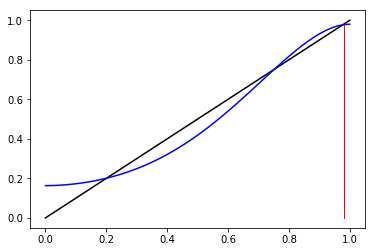

zoom


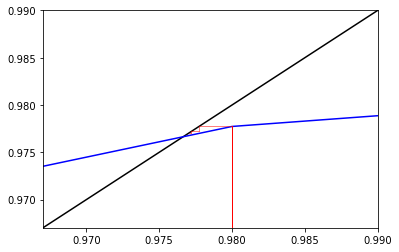

0.055
full size


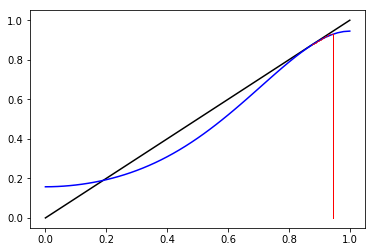

zoom


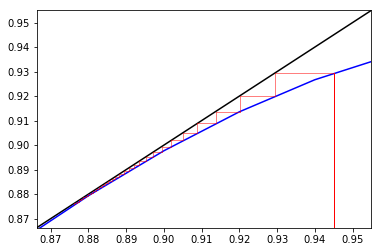

0.07
full size


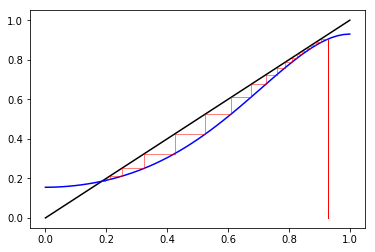

zoom


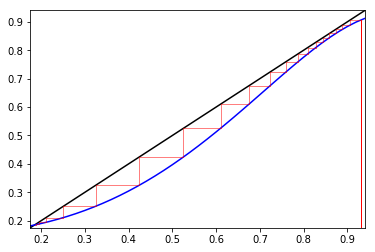

In [42]:
import numpy as np
import matplotlib.pyplot as plt
def psi(x):
    return (x**2+x**4+x**6)/3

def psiPrime(x):
    return (2*x + 4*x**3 + 6*x**5)/3

def psiDPrime(x):
    return (2 + 12*x**2 + 30*x**4)/3

def cobweb(f,rho, iterations=30):
    phiQ = 1-rho
    plt.plot([phiQ, phiQ], [0, f(phiQ,rho)], linewidth = 1, color = 'red')
    for counter in range(iterations):
        prev_phiQ = phiQ
        phiQ = f(phiQ,rho)
        plt.plot([prev_phiQ, phiQ], [phiQ, phiQ], linewidth = 0.5, color = 'red')
        plt.plot([phiQ, phiQ], [phiQ, f(phiQ,rho)], linewidth = 0.5, color = 'red')
    return phiQ
        
def f(x, rho):  #phi_Q(t) = f(phi_Q(t-1), rho)
    
    return (1-rho) * (psiPrime(x) + (1-x)*psiDPrime(x))/psiPrime(1)

phiQ = np.linspace(0,1,51)
phiA = 1-phiQ

for rho in [0.02, 0.055, 0.07]:
    print(rho)
    plt.figure(1)
    plt.clf()
    nextphiQ = (1-rho) * (psiPrime(phiQ) + phiA*psiDPrime(phiQ))/psiPrime(1)

    print('full size')
    plt.plot(phiQ, phiQ, color = 'black')
    plt.plot(phiQ, nextphiQ, color = 'blue')
    limit = cobweb(f, rho)
    plt.show()
    
    print('zoom')
    plt.figure(2)
    plt.plot(phiQ, phiQ, color = 'black')
    plt.plot(phiQ, nextphiQ, color = 'blue')
    limit = cobweb(f, rho)
    plt.axis(ymin=limit-0.01, xmin=limit-0.01, xmax = (1-rho)+0.01, ymax = 1-rho+0.01)
    plt.show()

Notice how the fixed point of interest suddenly disappears and then it converges to a lower fixed point.

Now we'll plot the location of the limit as rho changes.

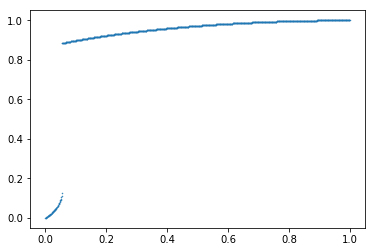

In [51]:
import numpy as np
import matplotlib.pyplot as plt
def psi(x):
    return (x**2+x**4+x**6)/3

def psiPrime(x):
    return (2*x + 4*x**3 + 6*x**5)/3

def psiDPrime(x):
    return (2 + 12*x**2 + 30*x**4)/3
        
def f(x, rho):  #phi_Q(t) = f(phi_Q(t-1), rho)
    
    return (1-rho) * (psiPrime(x) + (1-x)*psiDPrime(x))/psiPrime(1)

def getA(phiQ, rho):
    return 1- (1-rho)*(psi(phiQ) + (1-phiQ)*psiPrime(phiQ))
limit = []
rhos = np.linspace(0,1, 1001)
for rho in rhos:
    phiQ = 1-rho
    for counter in range(100):
        phiQ = f(phiQ, rho)
    limit.append(getA(phiQ, rho))


plt.plot(rhos, limit, '.', markersize = 1)
plt.show()

See how it looks like $c_1 - c_2 \sqrt{x_0-x}$ as $x$ increases to $x_0$?  This is in some ways similar to the first order transition, but the existence of some sort of singularity in the slope is not.  We often call this a hybrid transition.